In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

# Initialize transforms
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])

# Import the train and test data from a folder
train_data = torchvision.datasets.ImageFolder('data/train/', transform=train_transform)
test_data = torchvision.datasets.ImageFolder('data/test/', transform=test_transform)

# Separate images into batches with dataloader
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

# Get each dataloader size
train_dataset_size = len(train_dataloader)
test_dataset_size = len(test_dataloader)

In [3]:
# Create a simple CNN class
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        conv1 = self.pool(self.relu(self.conv1(x)))
        conv2 = self.pool(self.relu(self.conv2(conv1)))
        flatten = self.flatten(conv2)
        # print(flatten.shape) # To set linear layers in_features size
        fc1 = self.relu(self.fc1(flatten))
        fc2 = self.relu(self.fc2(fc1))
        fc3 = self.fc3(fc2)
        return fc3

# Create an instance of the CovNet class
model = ConvNet()

In [4]:
# Initialize loss function (CrossEntropyLoss for multiclass classification)
loss_fn = nn.CrossEntropyLoss()

# Initialize optimizer (SGD - Stochastic Gradient Descent, lr - learning rate, momentum - momentum factor)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [5]:
epochs = 100

# To visualize the training operation
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

# In order to get the best model from the training operation
best_accuracy = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

# Training begins here
for epoch in range(1, epochs+1):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    
    # This inner loop is for training by batches
    for i, (images, labels) in enumerate(train_dataloader, 1):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, Backward and Optimize
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # Get loss and accuracy results
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        corrects = torch.sum(preds == labels)
        accuracy = corrects.item() / len(labels)
        train_accuracy += accuracy
        print(f'Train Mode | Epoch: {epoch} | Step: {i} | Loss: {loss.item()} | Accuracy: {accuracy}')

    # Append train_loss and train_accuracy results to the lists by batches to visualize
    train_loss = train_loss / train_dataset_size
    train_losses.append(train_loss)
    train_accuracy = train_accuracy / train_dataset_size
    train_accuracies.append(train_accuracy)
    
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0

    # Test section begins here
    # Note: I put the test section in the training loop because I wanted to get the best model according to the test accuracy
    with torch.inference_mode():
        for i, (images, labels) in enumerate(test_dataloader, 1):
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            _, preds = torch.max(outputs, 1)
            corrects = torch.sum(preds == labels)
            accuracy = corrects.item() / len(labels)
            test_accuracy += accuracy
            test_loss += loss.item()
            print(f'Test Mode | Epoch: {epoch} | Step: {i} | Loss: {loss.item()} | Accuracy: {accuracy}')
    
    # Append test_loss and test_accuracy results to the lists by batches to visualize
    test_loss = test_loss / test_dataset_size
    test_losses.append(test_loss)
    test_accuracy = test_accuracy / test_dataset_size
    test_accuracies.append(test_accuracy)

    # Get the best model according to the test accuracy
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'New best accuracy: {best_accuracy}')

# Set the best model as default model
model.load_state_dict(best_model_wts)
print(f'The final best accuracy: {best_accuracy}')

Train Mode | Epoch: 1 | Step: 1 | Loss: 0.6889230608940125 | Accuracy: 0.5625
Train Mode | Epoch: 1 | Step: 2 | Loss: 0.6925773024559021 | Accuracy: 0.5
Train Mode | Epoch: 1 | Step: 3 | Loss: 0.6912074089050293 | Accuracy: 0.5625
Train Mode | Epoch: 1 | Step: 4 | Loss: 0.6927842497825623 | Accuracy: 0.5
Train Mode | Epoch: 1 | Step: 5 | Loss: 0.6899026036262512 | Accuracy: 0.59375
Train Mode | Epoch: 1 | Step: 6 | Loss: 0.6909468173980713 | Accuracy: 0.53125
Train Mode | Epoch: 1 | Step: 7 | Loss: 0.6909534931182861 | Accuracy: 0.625
Train Mode | Epoch: 1 | Step: 8 | Loss: 0.6959980130195618 | Accuracy: 0.4
Test Mode | Epoch: 1 | Step: 1 | Loss: 0.6866862177848816 | Accuracy: 0.6875
Test Mode | Epoch: 1 | Step: 2 | Loss: 0.6854537725448608 | Accuracy: 0.71875
Test Mode | Epoch: 1 | Step: 3 | Loss: 0.6954200267791748 | Accuracy: 0.34375
Test Mode | Epoch: 1 | Step: 4 | Loss: 0.6930227875709534 | Accuracy: 0.53125
Test Mode | Epoch: 1 | Step: 5 | Loss: 0.6975253224372864 | Accuracy: 0.3

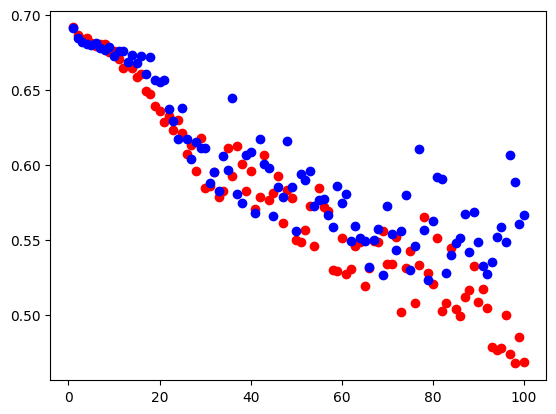

In [6]:
# Visualize the losses by epochs
plt.scatter(range(1,len(train_losses)+1), train_losses, c='r')
plt.scatter(range(1, len(test_losses)+1), test_losses, c='b')
plt.show()

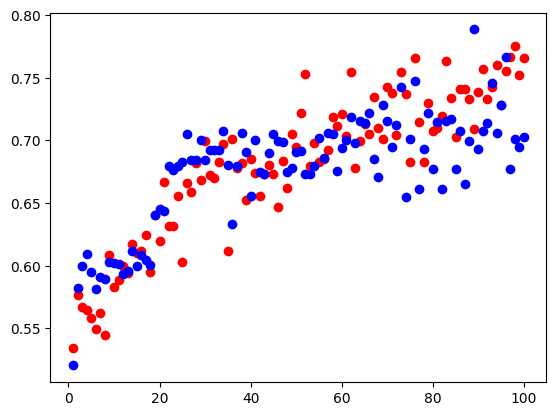

In [7]:
# Visualize the accuracy by epochs
plt.scatter(range(1,len(train_accuracies)+1), train_accuracies, c='r')
plt.scatter(range(1,len(test_accuracies)+1), test_accuracies, c='b')
plt.show()

In [8]:
# Test the model with a single image
from PIL import Image
pil_image = Image.open('ant.jpg')

# Apply transform to the image
image = test_transform(pil_image)

# Make a prediction (unsqueeze the image to set it as a batch, squeeze the result to reduce the dimension, softmax the result to convert the prediction to the percent)
prediction = model(image.unsqueeze(dim=0)).squeeze(0).softmax(0)

# Get the id of the maximum score in the prediction
class_id = prediction.argmax().item()

# Get the score of the result
score = prediction[class_id].item()

# Get the category name
category_name = test_data.classes[class_id]

print(f'Category name of the image: {category_name}, Score: {100 * score:.1f}%')

Category name of the image: ants, Score: 68.3%


In [9]:
# Save the model
torch.save(model.state_dict(), 'BestModel.pth')